# Fighters' survival analysis

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 15})
plt.rc('axes', labelsize=20)
plt.rcParams['xtick.labelsize'] = 20
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['pdf.fonttype'] = 42

path_cwd = os.getcwd()

## Preamble: Basic functions to compute scenarios

In [3]:
def tullock(resource_focal: float, resource_enemy: float, gamma: float):
    resource_ratio = resource_enemy / resource_focal
    return 1.0 / (1.0 + np.power(resource_ratio, gamma))

def probability_scenario_total_victory(resource_focal: float, resource_enemy: np.array, gamma: float):
    return np.prod([tullock(resource_focal, re, gamma) for re in resource_enemy])

def probability_scenario_single_defeat(resource_focal: float, resource_enemy: np.array, gamma: float):    
    prob = np.sum(np.asarray([(1.0 - tullock(resource_focal, resource_enemy[i], gamma)) *
                   np.prod([tullock(resource_focal, re, gamma) for j, re in enumerate(resource_enemy) if j != i])
                   for i in range(len(resource_enemy))]))

    return prob

def probability_scenario_double_victory(resource_focal: float, resource_enemy: np.array, gamma: float):
    p_win_ns = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[1], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[2], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma))

    p_win_ne = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[2], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[1], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma))

    p_win_nw = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[1], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[2], gamma))

    p_win_se = tullock(resource_focal, resource_enemy[1], gamma) \
        * tullock(resource_focal, resource_enemy[2], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma))

    p_win_sw = tullock(resource_focal, resource_enemy[1], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[2], gamma))
  
    p_win_ew = tullock(resource_focal, resource_enemy[2], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[1], gamma))
    
    return (p_win_ns + p_win_ne + p_win_nw + p_win_se + p_win_sw + p_win_ew)

def probability_scenario_single_victory(resource_focal: float, resource_enemy: np.array, gamma: float):
    prob = np.sum(np.asarray([tullock(resource_focal, resource_enemy[i], gamma) *
               np.prod([(1.0 - tullock(resource_focal, re, gamma)) for j, re in enumerate(resource_enemy) if j != i])
               for i in range(len(resource_enemy))]))
    
    return prob

def probability_scenario_total_defeat(resource_focal: float, resource_enemy: np.array, gamma: float):
    prob = np.prod([(1.0 - tullock(resource_focal, re, gamma)) for re in resource_enemy])
    return prob

def reward_event_victory(resource_enemy: float, fights_enemy: float, rho: float):
    return rho * resource_enemy / fights_enemy

def reward_event_defeat(resource_focal: float, rho: float):
    return -rho * resource_focal / 4.0

def reward_scenario_total_victory(resource_enemy: np.array, fights_enemy: np.array, rho: float):
    return rho * np.sum(resource_enemy / fights_enemy)

def reward_scenario_single_defeat(
        resource_focal: float, 
        winner_resource_enemy: np.array, 
        winner_fights_enemy: np.array, 
        rho: float
        ):
    return rho * (np.sum(winner_resource_enemy / winner_fights_enemy) - resource_focal / 4.0)

def reward_scenario_double_victory(
        resource_focal: float, 
        won_resource_enemy: np.array, 
        won_fights_enemy: np.array, 
        rho: float
        ):
    return rho * (np.sum(won_resource_enemy / won_fights_enemy) - resource_focal / 2.0)

def reward_scenario_total_defeat(resource_focal: float, rho=float):
    return -rho * resource_focal

def reward_scenario_single_victory(
        resource_focal: float, 
        won_resource_enemy: float, 
        won_fights_enemy: float, 
        rho: float
        ):
    return rho * (won_resource_enemy / won_fights_enemy - 3.0 * resource_focal / 4.0)

def expected_gain_scenario_total_victory(
        resource_focal: float, 
        resource_enemy: np.array, 
        fights_enemy: np.array, 
        gamma: float, 
        rho: float
        ):
    return probability_scenario_total_victory(resource_focal, resource_enemy, gamma) \
        * reward_scenario_total_victory(resource_enemy, fights_enemy, rho)

def expected_gain_scenario_single_defeat(
        resource_focal: float, 
        resource_enemy: np.array, 
        fights_enemy: np.array, 
        gamma: float, 
        rho: float
        ):
    return np.sum(np.asarray([(1.0 - tullock(resource_focal, resource_enemy[i], gamma)) *
                   np.prod([tullock(resource_focal, re, gamma) for j, re in enumerate(resource_enemy) if j != i])  *
                   rho * (np.sum(resource_enemy / fights_enemy) - resource_enemy[i] / fights_enemy[i] - resource_focal / 4.0)
                   for i in range(len(resource_enemy))]))

def expected_gain_scenario_double_victory(
        resource_focal: float, 
        resource_enemy: np.array, 
        fights_enemy: np.array, 
        gamma: float, 
        rho: float
        ):
    eg_win_ns = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[1], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[2], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma)) \
                * rho * (resource_enemy[0] / fights_enemy[0] + resource_enemy[1] / fights_enemy[1] - resource_focal / 2.0)
    
    eg_win_ne = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[2], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[1], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma)) \
                    * rho * (resource_enemy[0] / fights_enemy[0] + resource_enemy[2] / fights_enemy[2] - resource_focal / 2.0)
    
    eg_win_nw = tullock(resource_focal, resource_enemy[0], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[1], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[2], gamma)) \
                    * rho * (resource_enemy[0] / fights_enemy[0] + resource_enemy[3] / fights_enemy[3] - resource_focal / 2.0)
    
    eg_win_se = tullock(resource_focal, resource_enemy[1], gamma) \
        * tullock(resource_focal, resource_enemy[2], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[3], gamma)) \
                    * rho * (resource_enemy[1] / fights_enemy[1] + resource_enemy[2] / fights_enemy[2] - resource_focal / 2.0)
    
    eg_win_sw = tullock(resource_focal, resource_enemy[1], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[2], gamma)) \
                    * rho * (resource_enemy[1] / fights_enemy[1] + resource_enemy[3] / fights_enemy[3] - resource_focal / 2.0)
    
    eg_win_ew = tullock(resource_focal, resource_enemy[2], gamma) \
        * tullock(resource_focal, resource_enemy[3], gamma) \
            * (1.0 - tullock(resource_focal, resource_enemy[0], gamma)) \
                * (1.0 - tullock(resource_focal, resource_enemy[1], gamma)) \
                    * rho * (resource_enemy[2] / fights_enemy[2] + resource_enemy[3] / fights_enemy[3] - resource_focal / 2.0)
    
    return (eg_win_ns + eg_win_ne + eg_win_nw + eg_win_se + eg_win_sw + eg_win_ew)

def expected_gain_scenario_single_victory(
        resource_focal: float, 
        resource_enemy: np.array, 
        fights_enemy: np.array, 
        gamma: float, 
        rho: float
        ):
    return np.sum(np.asarray([tullock(resource_focal, resource_enemy[i], gamma) * 
               np.prod([(1.0 - tullock(resource_focal, re, gamma)) for j, re in enumerate(resource_enemy) if j != i]) *
               rho * (resource_enemy[i] / fights_enemy[i] -  3.0 * resource_focal / 4.0)
               for i in range(len(resource_enemy))]))

def expected_gain_scenario_total_defeat(
        resource_focal: float, 
        resource_enemy: np.array, 
        gamma: float, 
        rho: float
        ):
    return probability_scenario_total_defeat(resource_focal, resource_enemy, gamma) \
        * reward_scenario_total_defeat(resource_focal, rho)

def expected_gain_total(
        resource_focal: float,
        resource_enemy: np.array,
        fights_enemy: np.array,
        gamma: float,
        rho: float,
):  
    eg_tv = expected_gain_scenario_total_victory(
        resource_focal=resource_focal, 
        resource_enemy=resource_enemy, 
        fights_enemy=fights_enemy, 
        gamma=gamma, 
        rho=rho,
        )

    eg_sd = expected_gain_scenario_single_defeat(
        resource_focal=resource_focal, 
        resource_enemy=resource_enemy, 
        fights_enemy=fights_enemy, 
        gamma=gamma, 
        rho=rho,
        )

    eg_dv = expected_gain_scenario_double_victory(
        resource_focal=resource_focal, 
        resource_enemy=resource_enemy, 
        fights_enemy=fights_enemy, 
        gamma=gamma, 
        rho=rho
        )

    eg_sv = expected_gain_scenario_single_victory(
        resource_focal=resource_focal, 
        resource_enemy=resource_enemy, 
        fights_enemy=fights_enemy, 
        gamma=gamma, 
        rho=rho,
        )

    eg_td = expected_gain_scenario_total_defeat(
        resource_focal=resource_focal, 
        resource_enemy=resource_enemy, 
        gamma=gamma, 
        rho=rho,
        )

    return (eg_tv + eg_sd + eg_dv + eg_sv + eg_td)   

## Tullock CSF

In [4]:
array_gamma = np.linspace(0.0, 1.0, 3000)

resource_focal = 1.0
resource_enemy = np.linspace(0.0, 4.0, 3000)

tullock_matrix = np.zeros((len(array_gamma), len(resource_enemy)))

for i, gamma in enumerate(array_gamma):
    for j, resource in enumerate(resource_enemy):
        tullock_matrix[i, j] = tullock(resource_focal=resource_focal, resource_enemy=resource, gamma=gamma)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


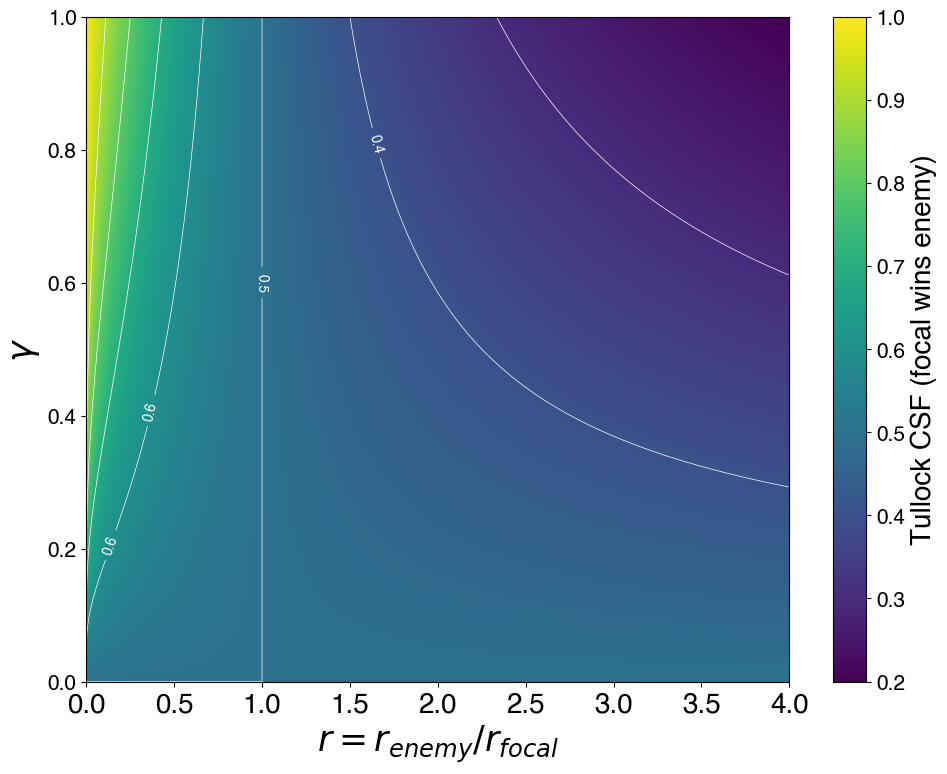

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = ax.imshow(tullock_matrix, interpolation='nearest', cmap='viridis', aspect='auto', origin='lower',
                    extent=[resource_enemy.min(), resource_enemy.max(), array_gamma.min(), array_gamma.max()])
cbar = fig.colorbar(heatmap, ax=ax)
cbar.set_label('Tullock CSF (focal wins enemy)', size=20)

ax.set_ylabel(r'$\gamma$', fontsize=25)
ax.set_xlabel(r'$r=r_{{enemy}}/r_{{focal}}$', fontsize=25)

X, Y = np.meshgrid(resource_enemy, array_gamma)
contours = ax.contour(X, Y, tullock_matrix, colors='white', linewidths=0.5)

manual_positions = [(0.2, 0.2), (0.5, 0.4), (1.0, 0.6), (1.5, 0.8)]
ax.clabel(contours, inline=True, fontsize=10, fmt='%1.1f', manual=manual_positions)

plt.tight_layout()

path_full_target = os.path.join(path_cwd, '..', 'figures')
filename_target = 'coopfight_tullock_heatmap'
extension_list = ['pdf', 'png']
if not os.path.exists(path_full_target):
    os.makedirs(path_full_target)
for ext in extension_list:
    full_name = os.path.join(path_full_target, filename_target + '.' + ext)
    plt.savefig(full_name, format=ext, bbox_inches='tight')

plt.show()

## Scenario probabilities

In [6]:
resource_focal = 1.0

resource_base = 1.0
resource_noise = 0.05

resource_north = 10.0 #np.random.normal(loc=resource_base, scale=resource_noise)
resource_south = 0.5 #np.random.normal(loc=resource_base, scale=resource_noise)
resource_east = 0.9 # np.random.normal(loc=resource_base, scale=resource_noise)
resource_west = 1.01 #np.random.normal(loc=resource_base, scale=resource_noise)

fights_north = 4
fights_south = 4
fights_east = 4
fights_west = 4

resource_enemy = np.array([resource_north, resource_south, resource_east, resource_west])
fights_enemy = np.array([fights_north, fights_south, fights_east, fights_west])

array_gamma = np.linspace(0.0, 1.0, 100)
len_array_gamma = len(array_gamma)
array_rho = np.linspace(0.0, 1.0, 100)
len_array_rho = len(array_rho)

prob_td_gamma = np.zeros(len_array_gamma)
prob_tv_gamma = np.zeros(len_array_gamma)
prob_dv_gamma = np.zeros(len_array_gamma)
prob_sv_gamma = np.zeros(len_array_gamma)
prob_sd_gamma = np.zeros(len_array_gamma)
reward_td_rho = np.zeros(len_array_rho)
reward_tv_rho = np.zeros(len_array_rho)

for i, rho in enumerate(array_rho):
    for j, gamma in enumerate(array_gamma):
        if i == 0:
            prob_td_gamma[j] = probability_scenario_total_defeat(resource_focal=resource_focal, resource_enemy=resource_enemy, gamma=gamma)
            prob_tv_gamma[j] = probability_scenario_total_victory(resource_focal=resource_focal, resource_enemy=resource_enemy, gamma=gamma)
            prob_dv_gamma[j] = probability_scenario_double_victory(resource_focal=resource_focal, resource_enemy=resource_enemy, gamma=gamma)
            prob_sv_gamma[j] = probability_scenario_single_victory(resource_focal=resource_focal, resource_enemy=resource_enemy, gamma=gamma)
            prob_sd_gamma[j] = probability_scenario_single_defeat(resource_focal=resource_focal, resource_enemy=resource_enemy, gamma=gamma)

    reward_td_rho[i] = reward_scenario_total_defeat(resource_focal=resource_focal, rho=rho)
    reward_tv_rho[i] = reward_scenario_total_victory(resource_enemy=resource_enemy, fights_enemy=fights_enemy, rho=rho)  

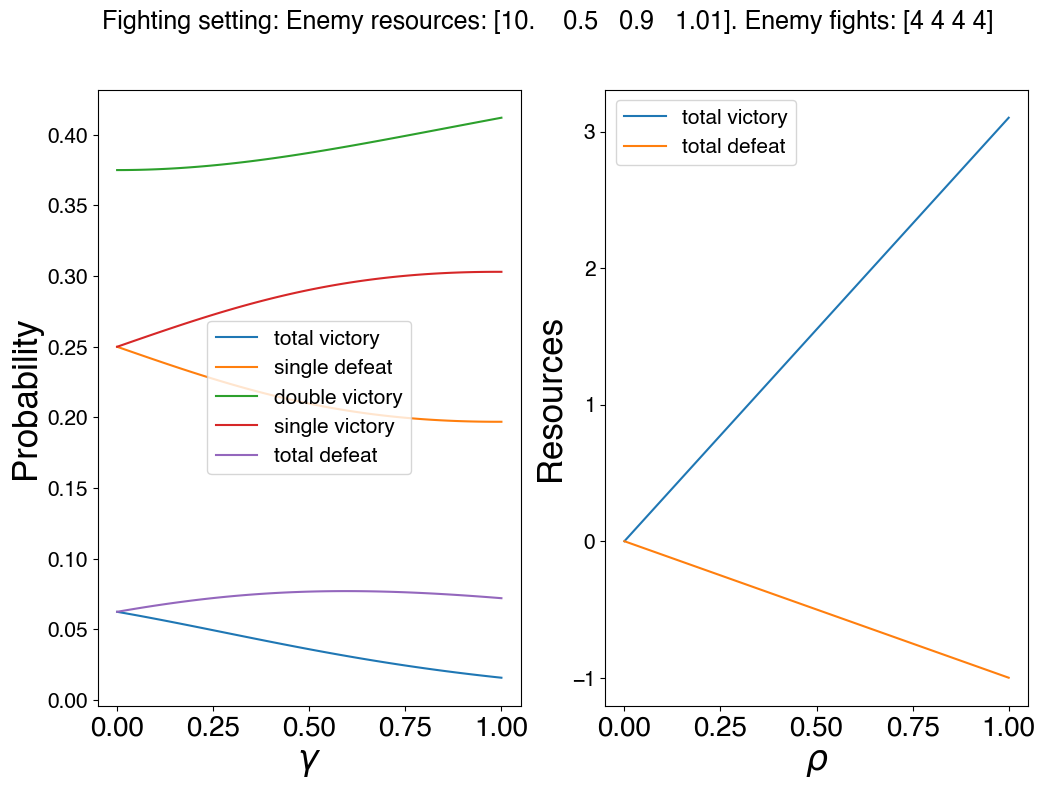

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

ax[0].plot(array_gamma, prob_tv_gamma, label='total victory')
ax[0].plot(array_gamma, prob_sd_gamma, label='single defeat')
ax[0].plot(array_gamma, prob_dv_gamma, label='double victory')
ax[0].plot(array_gamma, prob_sv_gamma, label='single victory')
ax[0].plot(array_gamma, prob_td_gamma, label='total defeat')
#ax[0].plot(array_gamma, prob_tv_gamma + prob_sd_gamma + prob_dv_gamma + prob_sv_gamma + prob_td_gamma, color='black', linestyle='dashed')

ax[0].set_ylabel(r'Probability', fontsize=25)
ax[0].set_xlabel(r'$\gamma$', fontsize=25)

ax[0].legend(loc='center')

ax[1].plot(array_rho, reward_tv_rho, label='total victory')
ax[1].plot(array_rho, reward_td_rho, label='total defeat')

ax[1].set_ylabel(r'Resources', fontsize=25)
ax[1].set_xlabel(r'$\rho$', fontsize=25)

ax[1].legend()

fig.suptitle('Fighting setting: Enemy resources: {0}. Enemy fights: {1}'.format(resource_enemy, fights_enemy))

plt.show()

## Expected gains

### Expected gain for fixed $\gamma$ and $\rho$

In [10]:
resource_focal = 1.0

resource_north = 1.0
resource_south = 0.2
resource_east = 0.1
resource_west = 0.1

fights_north = 4
fights_south = 4
fights_east = 4
fights_west = 4

gamma = 0.40
rho = 0.5

resource_enemy = np.array([resource_north, resource_south, resource_east, resource_west])
fights_enemy = np.array([fights_north, fights_south, fights_east, fights_west])

p_tv = probability_scenario_total_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma
    )

eg_tv = expected_gain_scenario_total_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    fights_enemy=fights_enemy, 
    gamma=gamma, 
    rho=rho,
    )

print("Total victory event probability={0}, Expected gain={1}".format(p_tv, eg_tv))

p_sd = probability_scenario_single_defeat(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma
    )

eg_sd = expected_gain_scenario_single_defeat(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    fights_enemy=fights_enemy, 
    gamma=gamma, 
    rho=rho,
    )

print("Single defeat event probability={0}, Expected gain={1}".format(p_sd, eg_sd))

p_dv = probability_scenario_double_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma
    )

eg_dv = expected_gain_scenario_double_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    fights_enemy=fights_enemy, 
    gamma=gamma, 
    rho=rho
    )

print("Double victory event probability={0}, Expected gain={1}".format(p_dv, eg_dv))

p_sv = probability_scenario_single_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma
    )

eg_sv = expected_gain_scenario_single_victory(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    fights_enemy=fights_enemy, 
    gamma=gamma, 
    rho=rho,
    )

print("Single victory event probability={0}, Expected gain={1}".format(p_sv, eg_sv))

p_td = probability_scenario_total_defeat(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma
    )

eg_td = expected_gain_scenario_total_defeat(
    resource_focal=resource_focal, 
    resource_enemy=resource_enemy, 
    gamma=gamma, 
    rho=rho,
    )

print("Total defeat event probability={0}, Expected gain={1}".format(p_td, eg_td))

print("Total expected gain: {0}".format(eg_tv + eg_sd + eg_dv + eg_sv + eg_td))

print("All events add up to {0}".format(p_tv + p_sd + p_dv + p_sv + p_td))


Total victory event probability=0.16769967638092226, Expected gain=0.029347443366661397
Single defeat event probability=0.38931813627521566, Expected gain=-0.005367953139543175
Double victory event probability=0.31833843327395844, Expected gain=-0.058743856795417104
Single victory event probability=0.11068186372478434, Expected gain=-0.038219230342065834
Total defeat event probability=0.01396189034511929, Expected gain=-0.006980945172559645
Total expected gain: -0.07996454208292436
All events add up to 1.0


### 1-round total expected gain in $(\gamma, \rho)$-space

In [69]:
resource_focal = 1.0

resource_base = 1.0
resource_noise = 0.05

resource_north = 10.0 #np.random.normal(loc=resource_base, scale=resource_noise)
resource_south = 0.5 #np.random.normal(loc=resource_base, scale=resource_noise)
resource_east = 0.9 # np.random.normal(loc=resource_base, scale=resource_noise)
resource_west = 1.01 #np.random.normal(loc=resource_base, scale=resource_noise)

fights_north = 4
fights_south = 4
fights_east = 4
fights_west = 4

resource_enemy = np.array([resource_north, resource_south, resource_east, resource_west])
fights_enemy = np.array([fights_north, fights_south, fights_east, fights_west])

array_gamma = np.linspace(0.0, 1.0, 100)
array_rho = np.linspace(0.0, 1.0, 100)

dict_results_gamma_rho = {}

for i, rho in enumerate(array_rho):
    for j, gamma in enumerate(array_gamma):
        dict_results_gamma_rho[(rho, gamma)] = {}
    
        dict_results_gamma_rho[(rho, gamma)]['eg_total'] = expected_gain_total(
            resource_focal=resource_focal, 
            resource_enemy=resource_enemy, 
            fights_enemy=fights_enemy, 
            gamma=gamma, 
            rho=rho
            )

eg_matrix = np.zeros((len(array_gamma), len(array_rho)))

for i, gamma in enumerate(array_gamma):
    for j, rho in enumerate(array_rho):
        eg_matrix[i, j] = dict_results_gamma_rho[(rho, gamma)]['eg_total']


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


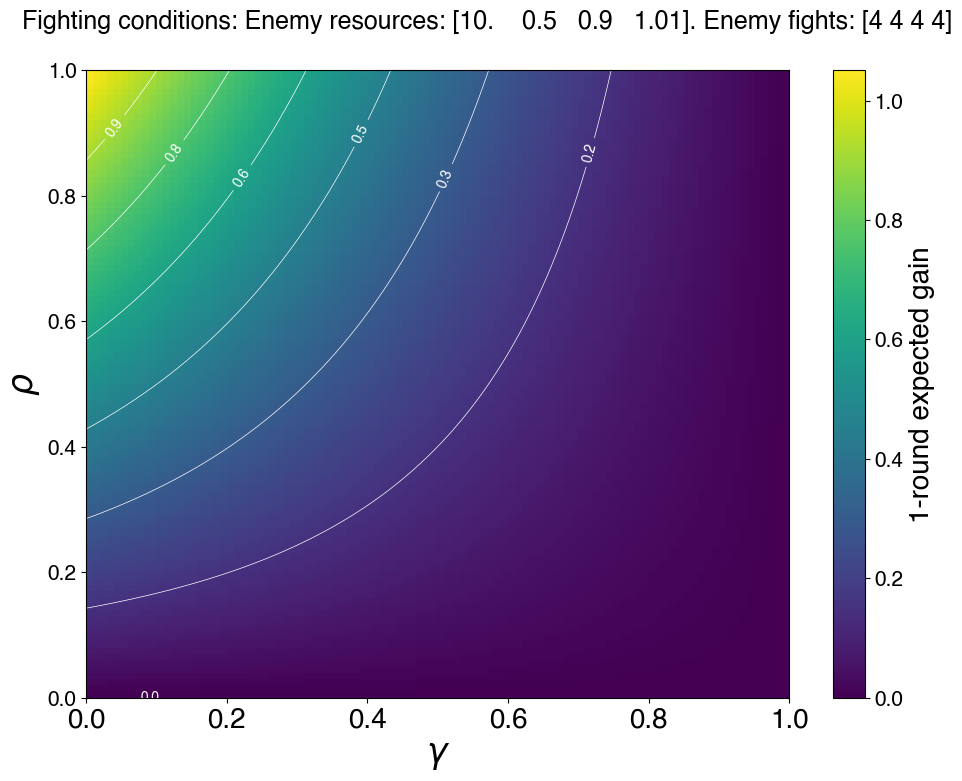

In [73]:
fig, ax = plt.subplots(figsize=(10, 8))

heatmap = ax.imshow(eg_matrix.T, interpolation='nearest', cmap='viridis', aspect='auto', origin='lower',
                    extent=[array_gamma.min(), array_gamma.max(), array_rho.min(), array_rho.max()])
cbar = fig.colorbar(heatmap, ax=ax)
cbar.set_label('1-round expected gain', size=20)

ax.set_ylabel(r'$\rho$', fontsize=25)
ax.set_xlabel(r'$\gamma$', fontsize=25)

fig.suptitle('Fighting conditions: Enemy resources: {0}. Enemy fights: {1}'.format(resource_enemy, fights_enemy))

X, Y = np.meshgrid(array_gamma, array_rho)
contours = ax.contour(X, Y, eg_matrix.T, colors='white', linewidths=0.5)
ax.clabel(contours, inline=True, fontsize=10, fmt='%1.1f')

plt.tight_layout()

path_full_target = os.path.join(path_cwd, '..', 'figures')
filename_target = 'coopfight_eg_total_heatmap_{0}_{1}_{2}'.format(resource_focal, resource_enemy, fights_enemy)
extension_list = ['pdf', 'png']
if not os.path.exists(path_full_target):
    os.makedirs(path_full_target)
for ext in extension_list:
    full_name = os.path.join(path_full_target, filename_target + '.' + ext)
    plt.savefig(full_name, format=ext, bbox_inches='tight')

plt.show()